# Задание 1 (5 баллов)
- Реализовать линейную или сверточную нейронную сеть из двух скрытых слоев.
- Обучить ее на датасете MNIST.
- Сравнить качество обучения при использовании различных функций активации (ReLU, GELU, Swish, Softplus обязательно, остальные – по желанию). Функции активации реализовывать!
- Построить график для функций активации точности от эпох..


## Шаг №0 - Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
import time

## Шаг №1 - Донастройка

In [2]:
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU(s), using GPU for training")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU for training")


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

TensorFlow version: 2.16.2
Found 1 GPU(s), using GPU for training


## Шаг №3 - Загрузка данных

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Шаг №4 - Определение класа для функций активации

In [4]:
class CustomActivation(tf.keras.layers.Layer):
    def __init__(self, activation_type='relu', **kwargs):
        super(CustomActivation, self).__init__(**kwargs)
        self.activation_type = activation_type

    def call(self, inputs):
        if self.activation_type == 'relu':
            # ReLU: f(x) = max(0, x)
            return tf.maximum(0.0, inputs)

        elif self.activation_type == 'gelu':
            # GELU: f(x) = x * Φ(x), где Φ(x) - кумулятивная функция нормального распределения
            # Аппроксимация: f(x) = 0.5 * x * (1 + tanh(sqrt(2/pi) * (x + 0.044715 * x^3)))
            cdf = 0.5 * (1.0 + tf.tanh(
                tf.sqrt(2.0 / np.pi) * (inputs + 0.044715 * tf.pow(inputs, 3))
            ))
            return inputs * cdf

        elif self.activation_type == 'swish':
            # Swish: f(x) = x * sigmoid(x)
            return inputs * tf.nn.sigmoid(inputs)

        elif self.activation_type == 'softplus':
            # Softplus: f(x) = ln(1 + e^x)
            return tf.math.log(1.0 + tf.exp(inputs))

        elif self.activation_type == 'tanh':
            # Tanh: f(x) = tanh(x)
            return tf.tanh(inputs)

        elif self.activation_type == 'sigmoid':
            # Sigmoid: f(x) = 1 / (1 + e^(-x))
            return tf.nn.sigmoid(inputs)

        else:
            raise ValueError(f"Неизвестная функция активации: {self.activation_type}")

    def get_config(self):
        config = super(CustomActivation, self).get_config()
        config.update({'activation_type': self.activation_type})
        return config

## Шаг №5 - Функция для создания модели

In [5]:
def create_linear_model(activation):
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(512),
        CustomActivation(activation),
        Dropout(0.2),
        Dense(256),
        CustomActivation(activation),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


## Шаг №6 - Определение параметров и запуск модели

In [6]:
activation_functions = ['relu', 'gelu', 'swish', 'softplus', 'tanh', 'sigmoid']

epochs = 5
batch_size = 128

histories = {}
final_accuracies = {}

for activation in activation_functions:
    print(f"\nОбучение линейной модели с функцией активации: {activation}")

    x_train_reshaped = x_train
    x_test_reshaped = x_test
    model = create_linear_model(activation)

    start_time = time.time()

    history = model.fit(
        x_train_reshaped, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test_reshaped, y_test),
        verbose=1
    )

    training_time = time.time() - start_time

    test_loss, test_acc = model.evaluate(x_test_reshaped, y_test, verbose=0)

    print(f"Функция активации: {activation}")
    print(f"Точность на тестовом наборе: {test_acc:.4f}")
    print(f"Время обучения: {training_time:.2f} секунд")

    histories[activation] = history.history
    final_accuracies[activation] = test_acc


Обучение линейной модели с функцией активации: relu


/Users/ivanbaskatov/2_Итма/Programming/PycharmProjects/MachineLearning/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-11 17:58:20.544440: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-11 17:58:20.544616: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-11 17:58:20.544627: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-11 17:58:20.544858: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-11 17:58:20.544879: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_facto

Epoch 1/5


2025-04-11 17:58:21.184049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8520 - loss: 0.4862 - val_accuracy: 0.9643 - val_loss: 0.1092
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9650 - loss: 0.1122 - val_accuracy: 0.9718 - val_loss: 0.0844
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9764 - loss: 0.0760 - val_accuracy: 0.9781 - val_loss: 0.0713
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9814 - loss: 0.0599 - val_accuracy: 0.9782 - val_loss: 0.0656
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9858 - loss: 0.0458 - val_accuracy: 0.9825 - val_loss: 0.0575
Функция активации: relu
Точность на тестовом наборе: 0.9825
Время обучения: 42.40 секунд

Обучение линейной модели с функцией активации: gelu
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8627 - loss: 0.4669 - val_accuracy: 0.9667 - val_loss: 0.1070
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9673 - loss: 0.1091 - val_accurac

## Шаг №7 - Построение графиков

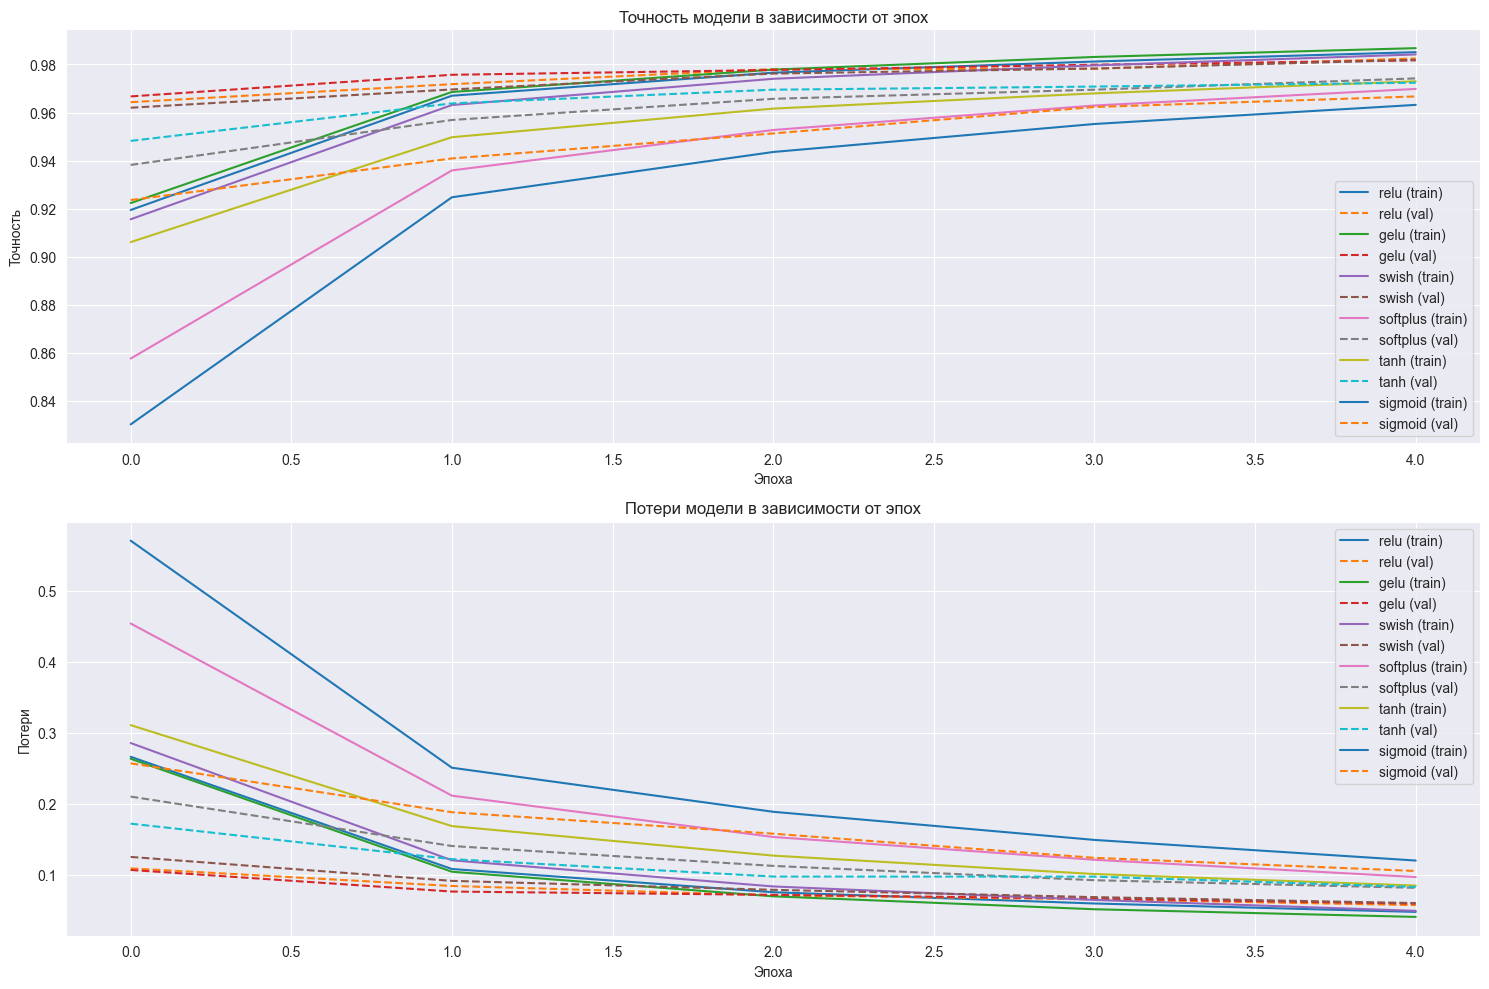

In [7]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
for activation, history in histories.items():
    plt.plot(history['accuracy'], label=f'{activation} (train)')
    plt.plot(history['val_accuracy'], label=f'{activation} (val)', linestyle='--')

plt.title('Точность модели в зависимости от эпох')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for activation, history in histories.items():
    plt.plot(history['loss'], label=f'{activation} (train)')
    plt.plot(history['val_loss'], label=f'{activation} (val)', linestyle='--')

plt.title('Потери модели в зависимости от эпох')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('activation_functions_comparison.png')
plt.show()

## Шаг №8 - Сравнение моделей

In [8]:
print("\nСравнение функций активации по финальной точности:")
for activation, accuracy in sorted(final_accuracies.items(), key=lambda x: x[1], reverse=True):
    print(f"{activation}: {accuracy:.4f}")


Сравнение функций активации по финальной точности:
relu: 0.9825
swish: 0.9819
gelu: 0.9817
softplus: 0.9742
tanh: 0.9724
sigmoid: 0.9667


## Шаг №9 - Визуализация функций активации

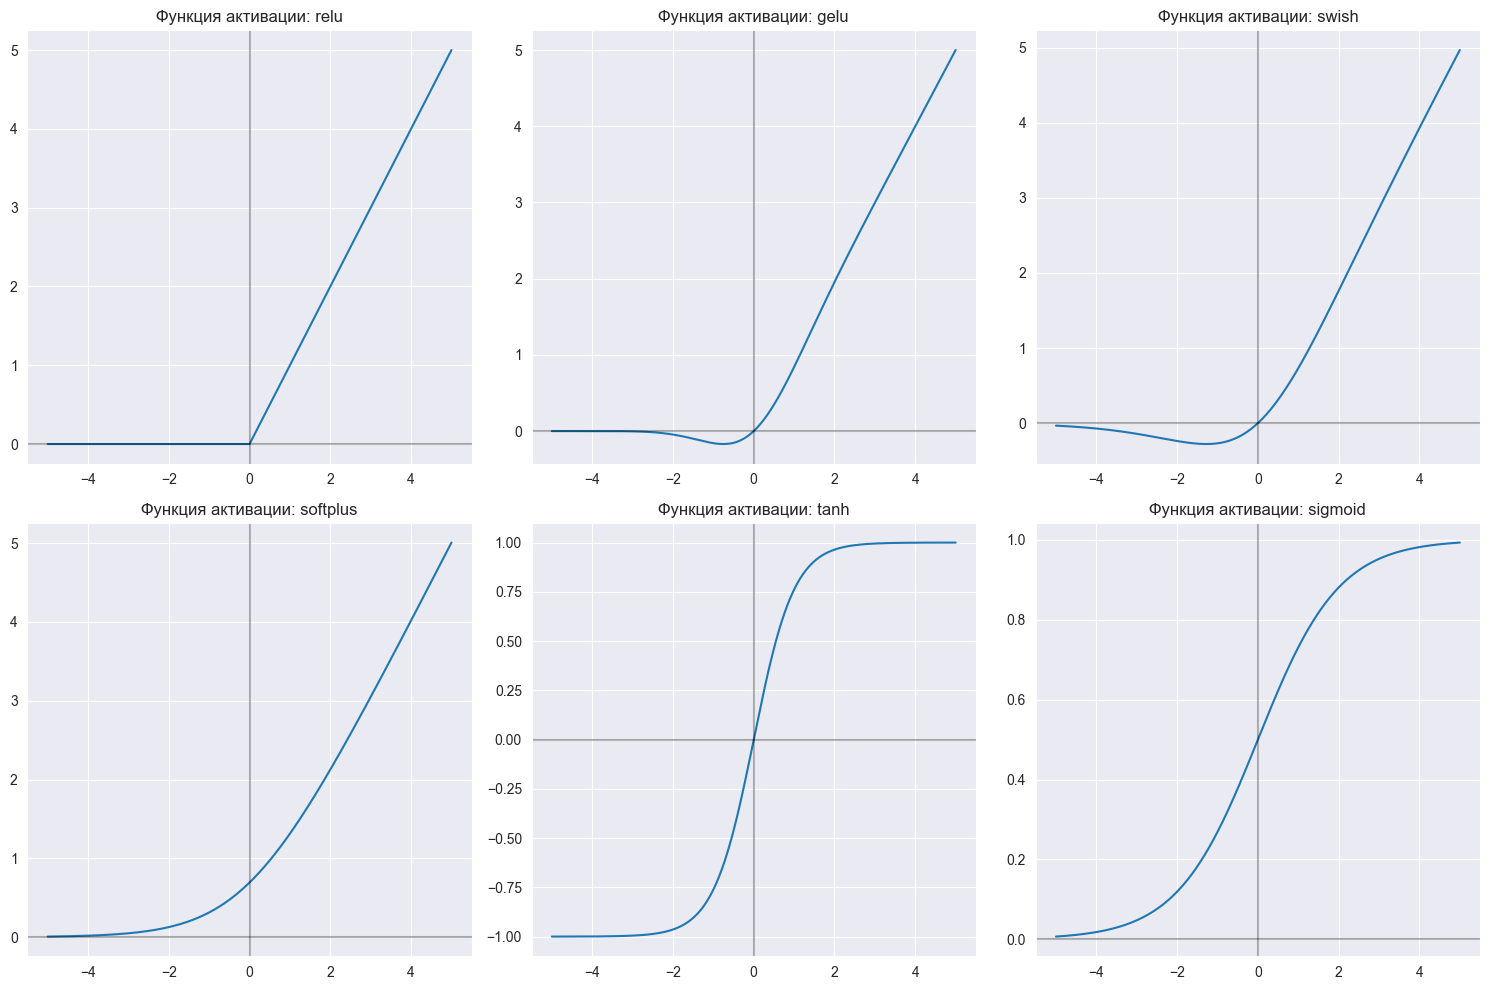

In [9]:
plt.figure(figsize=(15, 10))
x = np.linspace(-5, 5, 1000)

for i, activation in enumerate(activation_functions, 1):
    plt.subplot(2, 3, i)

    x_tensor = tf.constant(x, dtype=tf.float32)

    if activation == 'relu':
        y = tf.maximum(0.0, x_tensor)
    elif activation == 'gelu':
        cdf = 0.5 * (1.0 + tf.tanh(tf.sqrt(2.0 / np.pi) * (x_tensor + 0.044715 * tf.pow(x_tensor, 3))))
        y = x_tensor * cdf
    elif activation == 'swish':
        y = x_tensor * tf.nn.sigmoid(x_tensor)
    elif activation == 'softplus':
        y = tf.math.log(1.0 + tf.exp(x_tensor))
    elif activation == 'tanh':
        y = tf.tanh(x_tensor)
    elif activation == 'sigmoid':
        y = tf.nn.sigmoid(x_tensor)

    plt.plot(x, y.numpy())
    plt.title(f'Функция активации: {activation}')
    plt.grid(True)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.savefig('activation_functions.png')
plt.show()